In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import os
os.chdir("..")
from models.decode_utils import *
from utils import *
import pandas as pd

In [5]:
detail_path = "/public1/YHC/mod_result/oryza_mod_result.txt"
bisulfite_path = "/mnt/sdg2/oryza/Ory.CpG.gz.bismark.zero.cov"

In [6]:
# load bisulfite as dataframe
df = pd.read_csv(bisulfite_path, sep="\t", header=None)

In [7]:
# filter meth ratio 100 pos and 0 as neg
pos_df = df[(df[3] >= 100.0) & ((df[4] + df[5]) >= 10)]
neg_df = df[(df[3] <= 0.0) & ((df[4] + df[5]) >= 10)]

In [8]:
pos_df.loc[:,1] = pos_df[1].astype(str)
pos_df['key'] = pos_df[0] + "\t" + pos_df[1]
neg_df.loc[:,1] = neg_df[1].astype(str)
neg_df['key'] = neg_df[0] + "\t" + neg_df[1]

/tmp/ipykernel_1171592/1927433482.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1128' '1141' '1151' ... '14200' '14253' '14271']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pos_df.loc[:,1] = pos_df[1].astype(str)
/tmp/ipykernel_1171592/1927433482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df['key'] = pos_df[0] + "\t" + pos_df[1]
/tmp/ipykernel_1171592/1927433482.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['3954' '3957' '3958' ... '11426' '11567' '11571']' has dtype incompatible with int64, please explicitly cast to a compatible dt

In [9]:
pos_set = set(pos_df['key'].values.tolist())
neg_set = set(neg_df['key'].values.tolist())

In [10]:
pos, neg = [], []
for line in open(detail_path,'r'):
    line_s = line.strip().split("\t")
    key = line_s[3] + "\t" + line_s[4]
    if key in pos_set:
        pos.append(float(line_s[-1]))
    elif key in neg_set:
        neg.append(float(line_s[-1]))

In [11]:
pos = np.array(pos, dtype=np.float32)
neg = np.array(neg, dtype=np.float32)
neg = neg[np.random.permutation(np.arange(len(neg)))][:len(pos)]
assert(len(pos) == len(neg))

In [12]:
np.random.shuffle(pos)
np.random.shuffle(neg)

In [13]:
# making up labels
probs = np.concatenate([pos, neg])
labels = np.zeros(len(pos) + len(neg), dtype=np.int32)
labels[:len(pos)] = 1
preds = (probs> 0.5).astype(int)

In [14]:
TP, FP, TN, FN = compute(preds, labels)
(TP,FP,TN,FN, estimate_scores(TP, FP, TN, FN))

100%|██████████| 213987172/213987172 [11:06<00:00, 321219.21it/s]


(104136904,
 2737474,
 104256112,
 2856682,
 (0.973857517029105,
  0.9743860591169944,
  0.9733004369065638,
  0.9744145971516461,
  0.9738429454539531,
  0.02558540284835392,
  0.026699563093436275,
  0.9477156222832324))

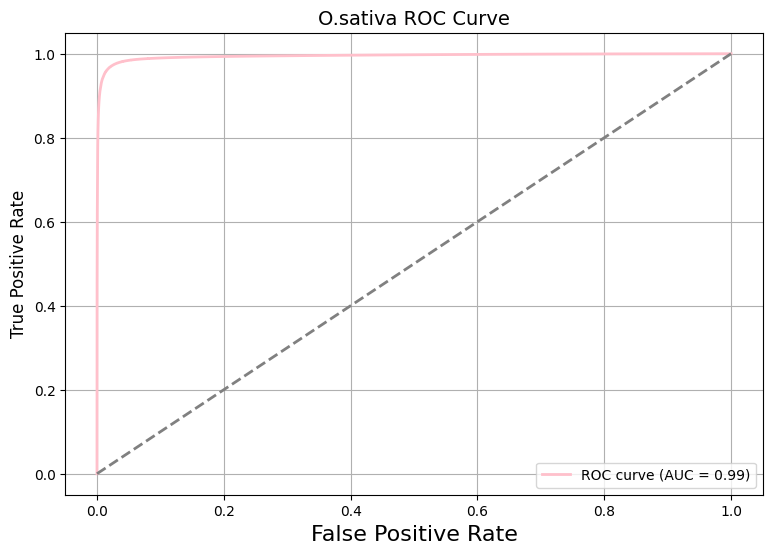

In [18]:
# compute roc curve
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color='pink', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('O.sativa ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

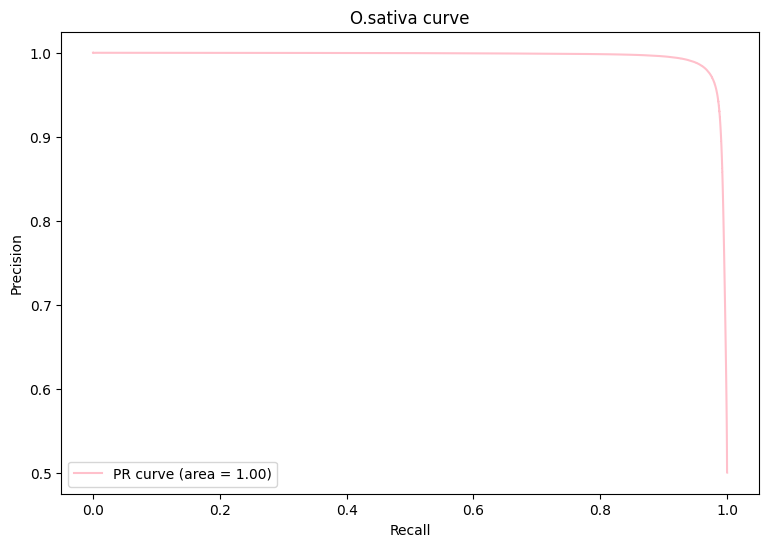

In [16]:
# 计算precision, recall和thresholds
precision, recall, thresholds = precision_recall_curve(labels, probs)

# 计算PR曲线下的AUC值
pr_auc = auc(recall, precision)

# 绘制PR曲线
plt.figure(figsize=(9, 6))
plt.plot(recall, precision, color='pink', label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('O.sativa curve')
plt.legend(loc="lower left")
plt.show()

In [17]:
print(roc_auc, pr_auc)

0.9945001594188041 0.9953976497249861
